# Lập trình thống kê với Python

# Kiểm định Mann-Whitney U

### BS. Lê Ngọc Khả Nhi

# Giới thiệu

Trong bài thực hành hôm nay, mời các bạn cùng Nhi code thủ công một kiểm định phi tham số Mann-Whitney U bằng ngôn ngữ Python nhé 

## Ôn lại lý thuyết

Mann-Whitney (1947) là một kiểm định phi tham số. Mục đích ban đầu của nó là dùng để kiểm tra sự tương đương về tính chất bất định của 2 mẫu phân phối, chứ không phải tập trung vào một giá trị nhất định nào. Sau này, test Mann-Whitney được mở rộng ý nghĩa, cho phép so sánh trung vị cũng như đặc tính phân phối như 1 giải pháp thay thế cho test t Student.

Nguyên tắc của test Mann Whitney là xếp hạng (thứ bâc) cho giá trị của mỗi cá thể sau khi trộn chung 2 phân nhóm với nhau, sau đó so sánh tổng thứ hạng mà mỗi phân nhóm đạt được. Nếu có sự khác nhau về đặc tính phân phối giữa 2 phân nhóm này, những trường hợp có hạng cao sẽ dồn về một phân nhóm, và những trường hợp hạng thấp sẽ dồn về phân nhóm còn lại. Nếu 2 phân nhóm có cùng đặc tính phân phối, mỗi thứ hạng sẽ có xác suất nằm ở mỗi phân nhóm như nhau.

Ứng dụng của kiểm định U của Mann-Whitney:

1. Thay thế cho test T student trong trường hợp : cỡ mẫu quá thấp, có vi phạm các giả định về phân phối chuẩn và/hoặc có outliers

2. Bắt buộc sử dụng test Mann-Whitney nếu đại lượng cần so sánh là một biến số không liên tục (thứ hạng, thang điểm, giả định lượng)

Ghi chú:

+ Một khi test t dùng được thì Mann-Whitney cũng dùng được, thậm chí ít bảo thủ hơn. Trong trường hợp test t cho ra kết quả không rõ nét, bạn có thể cân nhắc dùng test Mann-Whitney thay cho test t, với hy vọng tìm ra sự khác biệt.

+ Ý nghĩa của 2 loại test hoàn toàn khác nhau, nên cách diễn giải sẽ khác nhau. Test t so sánh 2 giá trị trung bình; test Mann-Whitney dựa vào thứ hạng và so sánh đặc tính phân phối (không bắt buộc là so sánh trung vị).

+ Một khi đã dùng test Mann-Whitney bạn cần phải mô tả đặc tính phân phối của 2 phân nhóm: đồ họa dùng histogram, boxplot, nếu làm mô tả thì phải tính Trung vị, Skewness, Kurtosis, bách phân vị, tứ phân vị...) thay vì dùng trung bình và độ lệch chuẩn, sai số chuẩn như thường lệ.

+ Cẩn trọng khi diễn giải: 

Chỉ trong trường hợp 2 phân nhóm F1 và F2 có cùng đặc tính phân phối (đồ thị hàm mật độ xác suất đồng dạng), nhưng lệch nhau trên thang đo của biến phụ thuộc Y bạn mới có quyền kết luận về khác biệt trung vị. Lúc này Test Mann-Whitney cho phép so sánh giá trị trung vị của Y giữa F1 và F2.

Nếu 2 phân nhóm F1, F2 có cùng đặc tính phân phối và gần như chồng lắp lên nhau, test Mann-Whitney cho ra kết quả âm tính, bạn có thể nói F1 và F2 cùng chung 1 quần thể

Nếu F1 và F2 có đặc tính phân phối hoàn toàn khác nhau (KDE plot cho ra 2 hình dạng khác biệt): Lúc này test Mann- Whitney chỉ có ý nghĩa chứng minh sự khác biệt về phân phối một cách chung chung, nhưng không có ý nghĩa so sánh trung vị hoặc bất cứ phân vị nào cả.

In [198]:
warning_status = "ignore"
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu

# Code thủ công Mann-Whitney U test

Ta dùng 1 class để tạo object cho mỗi quy trình kiểm định MWU. Mỗi object được khởi tạo với dữ liệu đầu vào df là 1 pandas và formula có nội dung: Tên biến phụ thuộc ~ tên biến phân nhóm, nội dung giả thuyết H1 có thể là 1 trong 4 loại: 'two-sided', 'one-sided', 'greater', 'less'. Cần kiểm tra biến phân nhóm có đúng 2 bậc giá trị hay không.

Quy trình này sẽ tạo ra 2 array x, y tương ứng 2 phân nhóm, tự động xác định chiều của giả thuyết H1 tùy theo loại tail và trung vị của x,y : H1 gồm : x < y, x > y hoặc x khác y (nếu tail = two-sided). Các tham số và dữ liệu sẽ được lưu trong 1 dictionary như 1 thuộc tính của class.

method kde_plot() cho phép so sánh trực quan 2 phân bố x, y

Ta dùng method test() với argument = ngưỡng ý nghĩa thống kê, thí dụ 0.05; để tiến hành kiểm định và xuất kết quả. Method này sẽ tính U, p value, và 2 effect-size là rank-biserial correlation coefficient (RBC) theo Wendt (1972) và common language effect size (CLES) của McGraw và Wong (1992), so sánh p với ngưỡng đã định, nếu nhỏ hơn thì có thể phủ định H0.

In [214]:
class Mann_Whitney_U():
    
    def __init__(self, df = None, formula = 'Y ~ F', tail='two-sided'):
        tail_set = {'two-sided', 'one-sided', 'greater', 'less'}
        f = [" ".join(i.split()) for i in formula.split('~')]
        df = df[f].dropna(how = 'any', axis = 0)
        
        try:
            assert(len(df[f[1]].unique()) == 2)
        except AssertionError:
            print(f'Yếu tố {f[1]} phải có 2 giá trị')
        else:
            k = list(df[f[1]].unique())
            x = df[f[0]][df[f[1]] == k[0]]
            y = df[f[0]][df[f[1]] == k[1]]
        
        try:
            assert(tail in tail_set)
        except AssertionError:
            print('Giá trị tail không hợp lệ')
        else:
            pass
        
        if tail == 'one-sided':
            tail = 'less' if np.median(x) < np.median(y) else 'greater'
        
        self._param = {'x': x,
                       'y': y,
                       'tail': tail,
                       'dep': f[0],
                       'fact': f[1],
                       'lev': k,}
    
    def kde_plot(self):
        plt.figure(figsize=(6,3))
        for i in [0,1]:
            sns.kdeplot((self._param['x'],self._param['y'])[i],
                     shade = True, 
                     alpha = 0.5, 
                     color = ['red','blue'][i],
                     label = self._param['lev'][i])
        plt.xlabel(self._param['dep'])
        
    def test(self, thres = 0.05):
        x,y = self._param['x'].values, self._param['y'].values
            
        u, p = mannwhitneyu(x,y,
                            use_continuity=True,
                            alternative=self._param['tail'])
            
        # CLES theo McGraw - Wong 1992
        diff = x[:, None] - y
        cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size
            
        # RBCES theo Wendt 1972
        rbc = 1 - (2 * u) / diff.size
            
        report = pd.DataFrame({'Giá trị U': u,
                                   'X': self._param['lev'][0],
                                   'Y':  self._param['lev'][1],
                                   'H1': {'greater':'X > Y',
                                         'less': 'X < Y',
                                         'two-sided': 'X'+u"\u2260"+'Y'}[self._param['tail']],
                                   'Giá trị p': p,
                                   'CLES': cles,
                                   'RBC': rbc,
                                   'Phủ định H0': 'Có' if p < thres else 'Không'}, 
                              index = [self._param['dep']])
        
        self.kde_plot()
        
        return report

# Sử dụng class Mann Whitney U

Nhi minh họa bằng bộ dữ liệu hepatitis rút gọn, với 5 biến định lượng và 2 biến phân nhóm

In [194]:
df = pd.read_csv('https://www.openml.org/data/get_csv/55/dataset_55_hepatitis.arff', na_values='?')
df = df[['AGE', 'SEX', 'BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME', 'Class']]
df.dropna(how = 'any', axis = 0, inplace = True)

df

,AGE,SEX,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,Class
3,31,female,0.7,46.0,52.0,4.0,80.0,LIVE
5,34,female,0.9,95.0,28.0,4.0,75.0,LIVE
10,39,female,1.3,78.0,30.0,4.4,85.0,LIVE
11,32,female,1.0,59.0,249.0,3.7,54.0,LIVE
12,41,female,0.9,81.0,60.0,3.9,52.0,LIVE
...,...,...,...,...,...,...,...,...
143,49,female,1.4,85.0,70.0,3.5,35.0,DIE
145,31,female,1.2,75.0,173.0,4.2,54.0,LIVE
147,70,female,1.7,109.0,528.0,2.8,35.0,DIE
153,53,male,1.5,81.0,19.0,4.1,48.0,LIVE


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 3 to 154
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AGE            83 non-null     int64  
 1   SEX            83 non-null     object 
 2   BILIRUBIN      83 non-null     float64
 3   ALK_PHOSPHATE  83 non-null     float64
 4   SGOT           83 non-null     float64
 5   ALBUMIN        83 non-null     float64
 6   PROTIME        83 non-null     float64
 7   Class          83 non-null     object 
dtypes: float64(5), int64(1), object(2)
memory usage: 5.8+ KB


## Thực hiện 1 kiểm định MWU cho 1 biến

Thí dụ Nhi cần so sánh Bilirubin giữa 2 phân nhóm Class = Live/Die, sẽ viết syntax như sau:

,Giá trị U,X,Y,H1,Giá trị p,CLES,RBC,Phủ định H0
BILIRUBIN,271.0,LIVE,DIE,X≠Y,0.004443,0.714706,0.468627,Có


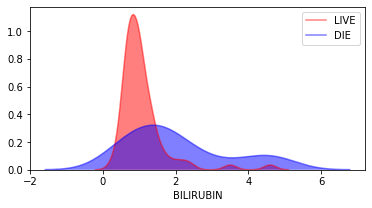

In [223]:
m = Mann_Whitney_U(df = df, formula = 'BILIRUBIN ~ Class', tail='two-sided')

m._param

m.test(0.01)

## Thực hiện hàng loạt kiểm định Mann Whitney U cho nhiều biến định lượng 

Nếu muốn làm hành loạt kiểm định MWU cho 1 danh sách biến định lượng, ta chỉ cần viết vòng lặp như sau: 

     Giá trị U     X    Y     H1  Giá trị p     CLES       RBC Phủ định H0
AGE      271.0  LIVE  DIE  X < Y   0.002366  0.72549  0.468627          Có
           Giá trị U     X    Y     H1  Giá trị p      CLES       RBC  \
BILIRUBIN      271.0  LIVE  DIE  X < Y   0.002222  0.714706  0.468627   

          Phủ định H0  
BILIRUBIN          Có  
               Giá trị U     X    Y     H1  Giá trị p      CLES       RBC  \
ALK_PHOSPHATE      347.0  LIVE  DIE  X < Y   0.027144  0.653922  0.319608   

              Phủ định H0  
ALK_PHOSPHATE       Không  
      Giá trị U     X    Y     H1  Giá trị p     CLES       RBC Phủ định H0
SGOT      505.5  LIVE  DIE  X < Y   0.481118  0.49902  0.008824       Không
         Giá trị U     X    Y     H1  Giá trị p      CLES       RBC  \
ALBUMIN      866.0  LIVE  DIE  X > Y   0.000012  0.835294 -0.698039   

        Phủ định H0  
ALBUMIN          Có  
         Giá trị U     X    Y     H1  Giá trị p      CLES       RBC  \
PROTIME      862.5  LIVE  DIE  X >

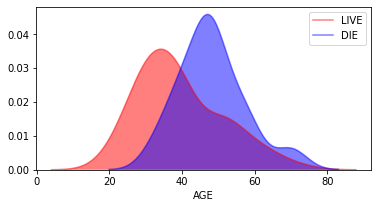

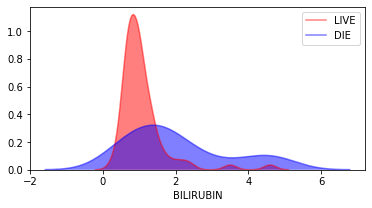

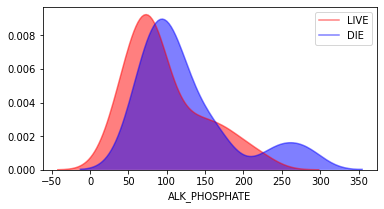

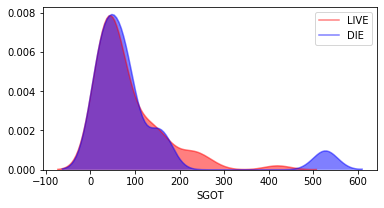

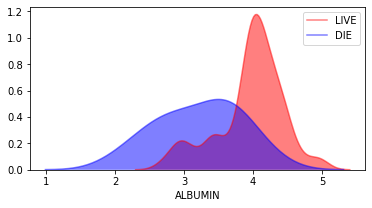

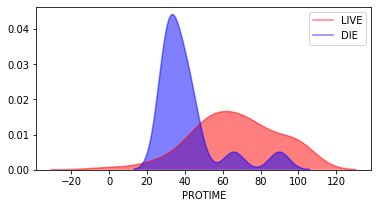

In [225]:
for v in ['AGE', 'BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']:
    print('='*20)
    m = Mann_Whitney_U(df = df, formula = f'{v} ~ Class', tail='one-sided')
    r = m.test(0.01)
    print(r)

## Thực hiện MWU test cho tất cả tổ hợp giữa biến định lượng và phân nhóm

Ta cũng có thể thực hiện hàng loạt MWU test cho tổ hợp tất cả cặp biến phân nhóm và định lượng có trong dataframe, bằng cách dùng iterator product trong itertools:

     Giá trị U     X    Y     H1  Giá trị p     CLES       RBC Phủ định H0
AGE      271.0  LIVE  DIE  X < Y   0.002366  0.72549  0.468627          Có
           Giá trị U     X    Y     H1  Giá trị p      CLES       RBC  \
BILIRUBIN      271.0  LIVE  DIE  X < Y   0.002222  0.714706  0.468627   

          Phủ định H0  
BILIRUBIN          Có  
               Giá trị U     X    Y     H1  Giá trị p      CLES       RBC  \
ALK_PHOSPHATE      347.0  LIVE  DIE  X < Y   0.027144  0.653922  0.319608   

              Phủ định H0  
ALK_PHOSPHATE       Không  
      Giá trị U     X    Y     H1  Giá trị p     CLES       RBC Phủ định H0
SGOT      505.5  LIVE  DIE  X < Y   0.481118  0.49902  0.008824       Không
         Giá trị U     X    Y     H1  Giá trị p      CLES       RBC  \
ALBUMIN      866.0  LIVE  DIE  X > Y   0.000012  0.835294 -0.698039   

        Phủ định H0  
ALBUMIN          Có  
         Giá trị U     X    Y     H1  Giá trị p      CLES       RBC  \
PROTIME      862.5  LIVE  DIE  X >

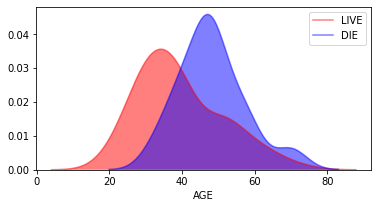

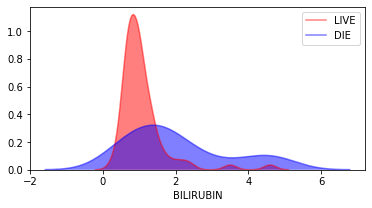

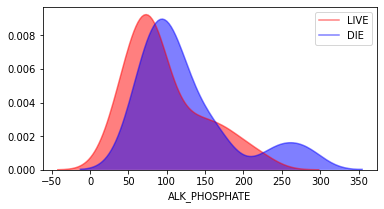

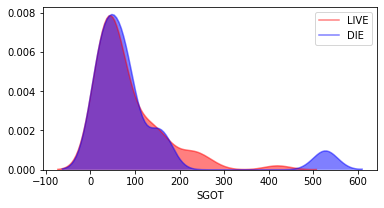

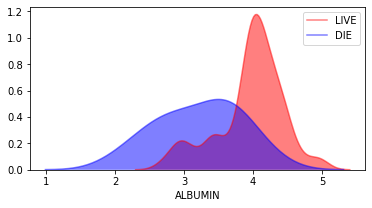

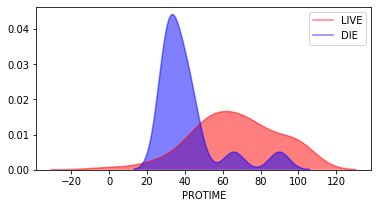

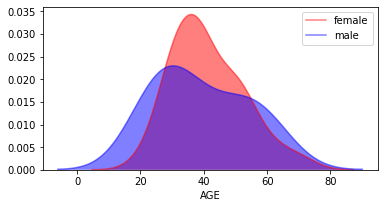

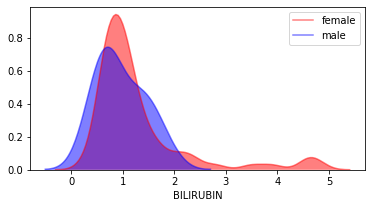

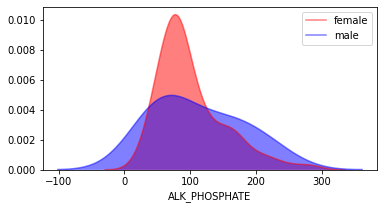

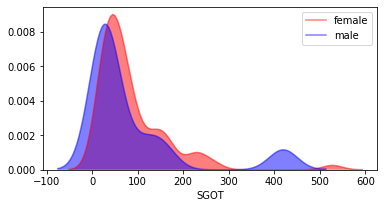

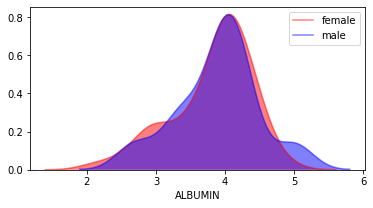

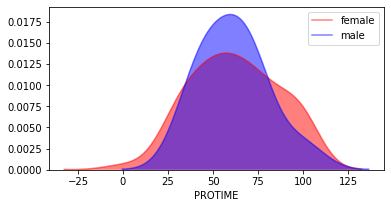

In [227]:
import itertools

for pair in itertools.product(['Class','SEX'],['AGE', 'BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']):
    print('='*20)
    m = Mann_Whitney_U(df = df, formula = f'{pair[1]} ~ {pair[0]}', tail='one-sided')
    print(m.test(0.01),sep = '\n')

Bài thực hành đến đây là hết, chúc các bạn viết code vui, hẹn gặp lại.


# Tài liệu tham khảo

Mann, H. B., & Whitney, D. R. (1947). On a test of whether one of two random variables is stochastically larger than the other. Annals of Mathematical Statistics, 18, 50–60. https://doi.org/10.1214/aoms/1177730491

Wendt, H. W. (1972). Dealing with a common problem in social science: A simplified rank-biserial coefficient of correlation based on the statistic. European Journal of Social Psychology, 2(4), 463–465. https://doi.org/10.1002/ejsp.2420020412

McGraw, K. O., & Wong, S. P. (1992). A common language effect size statistic. Psychological Bulletin, 111(2), 361–365. https://doi.org/10.1037/0033-2909.111.2.361